In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/MyDrive')

### d4rl utils

In [3]:
!pip install torch numpy matplotlib

In [4]:

!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libopengl-dev libosmesa6
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgl1-mesa-glx libgles-dev libgles1 libglew-dev
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev libosmesa6
  libosmesa6-dev
0 upgraded, 15 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,013 kB of archives.
After this operation, 19.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1 [101 kB]
Get:3 http://archive.ubuntu.com/ubuntu 

In [5]:

%pip install -f https://download.pytorch.org/whl/torch_stable.html \
                free-mujoco-py \
                einops \
                gym==0.23.1 \
                protobuf==3.20.1 \
                git+https://github.com/rail-berkeley/d4rl.git \
                mediapy \
                Pillow==9.0.0


Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/rail-berkeley/d4rl.git to /tmp/pip-req-build-_k24hu3q
  Running command git clone --filter=blob:none --quiet https://github.com/rail-berkeley/d4rl.git /tmp/pip-req-build-_k24hu3q
  Resolved https://github.com/rail-berkeley/d4rl.git to commit 89141a689b0353b0dac3da5cba60da4b1b16254d
  Preparing metadata (setup.py) ... done
ERROR: Ignored the following versions that require a different python version: 2.1.4 Requires-Python >=3.7.1,<3.11; 2.1.6 Requires-Python >=3.7.1,<3.11; 2.1.6.dev0 Requires-Python >=3.7.1,<3.11
ERROR: Could not find a version that satisfies the requirement free-mujoco-py (from versions: none)
ERROR: No matching distribution found for free-mujoco-py


### imports

In [6]:
!pip install stable_baselines3
!pip install gymnasium[mujoco]
!pip install just-d4rl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 20.5 MB/s eta 0:00:00


In [7]:
from just_d4rl import D4RLDataset, d4rl_offline_dataset, D4RLScoreNormalizer
import gymnasium as gym
import matplotlib.pyplot as plt

import torch
import numpy as np

In [8]:
import torch
import torch.nn as nn
from stable_baselines3.common import policies
from stable_baselines3.common.torch_layers import (
    BaseFeaturesExtractor,
    FlattenExtractor,
    MlpExtractor
)

class UnconditionalPolicy(policies.ActorCriticPolicy):
    """
    Policy that follows stable-baselines3's architecture for behavior cloning.
    This matches their implementation where features go through:
    1. Feature extraction (flattening for Box spaces)
    2. MLP extraction (separate networks for policy and value)
    3. Final action distribution
    """
    def __init__(
        self,
        observation_space,
        action_space,
        hidden_size=1024,
        depth=2,
        learning_rate=1e-3,
        dropout_p=0.1
    ):

        net_arch = dict(
            pi=[hidden_size] * depth,
            vf=[64]
        )


        super().__init__(
            observation_space=observation_space,
            action_space=action_space,
            lr_schedule=lambda _: learning_rate,
            net_arch=net_arch,
            activation_fn=nn.ReLU,
            features_extractor_class=FlattenExtractor,
            optimizer_class=torch.optim.Adam
        )

    def _build(self, lr_schedule):
        """
        Build the network following stable-baselines3's architecture.
        """

        self.features_extractor = self.features_extractor_class(self.observation_space)
        self.features_dim = self.features_extractor.features_dim


        self.mlp_extractor = MlpExtractor(
            self.features_dim,
            net_arch=self.net_arch,
            activation_fn=self.activation_fn,
        )


        self.value_net = nn.Linear(self.mlp_extractor.latent_dim_vf, 1)

        latent_dim_pi = self.mlp_extractor.latent_dim_pi
        self.action_net, self.log_std = self.action_dist.proba_distribution_net(
            latent_dim=latent_dim_pi,
            log_std_init=self.log_std_init
        )

def mle_loss(policy, obs, actions):

    _, log_prob, _ = policy.evaluate_actions(obs, actions)
    return -log_prob.mean()

### Online evluation utils

In [9]:
def evaluate_on_env(model, device, env, desired_return_target,
                    num_eval_ep=10, max_test_ep_len=1000,
                    state_mean=None, state_std=None, render=False,
                    state_normalization=True):

    eval_batch_size = 1
    results = {}
    total_reward = 0
    total_timesteps = 0

    state_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    if state_mean is None:
        state_mean = torch.zeros((state_dim,)).to(device)
    else:
        state_mean = torch.from_numpy(state_mean).to(device)

    if state_std is None:
        state_std = torch.ones((state_dim,)).to(device)
    else:
        state_std = torch.from_numpy(state_std).to(device)

    model.eval()
    model.to(device)

    with torch.no_grad():
        return_per_ep_log = []
        all_rewards = []

        for ep in range(num_eval_ep):
            desired_return = desired_return_target
            running_reward = 0
            reset_result = env.reset()
            if isinstance(reset_result, tuple):
                running_state, _ = reset_result
            else:
                running_state = reset_result

            running_reward = 0
            reward_per_ep = 0
            running_reward_log = []

            for t in range(max_test_ep_len):
                total_timesteps += 1
                desired_return -= running_reward*0.001


                state = torch.from_numpy(running_state).to(device, dtype=torch.float32)
                if state_normalization:
                    state = (state - state_mean) / state_std

                if len(state.shape) == 1:
                    state = state.unsqueeze(0)
                s_rtg = torch.cat((state, torch.tensor([desired_return]).to(device).reshape(-1,1)), dim=1)
                actions = model._predict(s_rtg, deterministic=True)


                step_result = env.step(actions.cpu().numpy().flatten())
                if len(step_result) == 5:  # Gymnasium style
                    running_state, running_reward, terminated, truncated, _ = step_result
                    done = terminated or truncated
                else:  # Old Gym style
                    running_state, running_reward, done, _ = step_result

                running_reward_log.append(running_reward)

                total_reward += running_reward
                reward_per_ep += running_reward

                if render:
                    env.render()
                if done:
                    print('sum of reward per episode: ', reward_per_ep)
                    return_per_ep_log.append(reward_per_ep)
                    break

    t = np.arange(len(running_reward_log))
    plt.plot(t, np.array(running_reward_log), 'b')
    plt.show()

    results['eval/avg_reward'] = total_reward / num_eval_ep
    results['eval/avg_ep_len'] = total_timesteps / num_eval_ep
    results['eval/std_returns'] = np.std(return_per_ep_log)
    results['eval/all_rewards'] = all_rewards

    return results

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
import gymnasium as gym

import numpy as np
import collections
import pickle

eval_env = gym.make('HalfCheetah-v4')
dataset_name = "halfcheetah-medium-expert-v2"
dataset = d4rl_offline_dataset(dataset_name)
get_normalized_score = D4RLScoreNormalizer(dataset_name)
return_target = 12000*0.001 #use 3600 for hopper and 5000 for walker2d



N = dataset["rewards"].shape[0]
data_ = collections.defaultdict(list)

use_timeouts = False
if "timeouts" in dataset:
    use_timeouts = True

episode_step = 0
paths = []
for i in range(N):
    done_bool = bool(dataset["terminals"][i])
    if use_timeouts:
        final_timestep = dataset["timeouts"][i]
    else:
        final_timestep = episode_step == 1000 - 1
    for k in [
        "observations",
        "next_observations",
        "actions",
        "rewards",
        "terminals",
    ]:
        data_[k].append(dataset[k][i])
    if done_bool or final_timestep:
        episode_step = 0
        episode_data = {}
        for k in data_:
            episode_data[k] = np.array(data_[k])
        paths.append(episode_data)
        data_ = collections.defaultdict(list)
    episode_step += 1

returns = np.array([np.sum(p["rewards"]) for p in paths])
num_samples = np.sum([p["rewards"].shape[0] for p in paths])
print(f"Number of samples collected: {num_samples}")
print(
    f"Trajectory returns: mean = {np.mean(returns)}, std = {np.std(returns)}, max = {np.max(returns)}, min = {np.min(returns)}"
)

with open(f"{dataset_name}.pkl", "wb") as f:
    pickle.dump(paths, f)



/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


load datafile: 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


Dataset loaded and saved at: /root/.d4rl/datasets/halfcheetah_medium_expert-v2.hdf5
Number of samples collected: 1997002
Trajectory returns: mean = 7703.63037109375, std = 2966.797607421875, max = 11239.41796875, min = -309.6566162109375


In [11]:
def discount_cumsum(x, gamma=1.):
    ret = np.zeros_like(x)
    ret[-1] = x[-1]
    for t in reversed(range(x.shape[0] - 1)):
        ret[t] = x[t] + gamma * ret[t + 1]
    return ret

In [12]:
rtgs = []
states = []
actions = []
for p in paths:
  states.append(p['observations'])
  actions.append(p['actions'])
  rtg = discount_cumsum(p['rewards'], gamma=1.)
  rtgs.append(rtg)

In [13]:
returns = np.concatenate(rtgs)
states = np.concatenate(states)
actions = np.concatenate(actions)

In [14]:
returns.shape

(1997002,)

In [15]:
states_mean = states.mean(axis=0)
states_std = states.std(axis=0) + 1e-6

In [16]:
normalized_states = (states-states_mean)/states_std

In [17]:
scaled_returns = returns / 1000

In [18]:
print(states.shape)
print(scaled_returns.shape)

(1997002, 17)
(1997002,)


In [19]:
hidden_dim = 128
act_dim = actions.shape[1]
obs_dim = states.shape[1]
lr = 1e-4
weight_decay = 1e-4
epochs = 2000
device = 'cuda'

In [20]:
obs_space=gym.spaces.Box(np.concatenate([eval_env.observation_space.low,np.array([-np.inf])]),
               np.concatenate([eval_env.observation_space.high,np.array([+np.inf])] ), shape=(eval_env.observation_space.shape[0]+1,))


/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [21]:
actor = UnconditionalPolicy(
    observation_space=obs_space,
    action_space=eval_env.action_space,
    hidden_size=1024,
    depth=2
)

In [22]:
actor

UnconditionalPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=18, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): ReLU()
    )
    (value_net): Sequential(
      (0): Linear(in_features=18, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (value_net): Linear(in_features=64, out_features=1, bias=True)
  (action_net): Linear(in_features=1024, out_features=6, bias=True)
)

In [23]:
optimizer = torch.optim.Adam(actor.parameters(),
                                    lr=lr,
                                    weight_decay=weight_decay,
                                    )

In [24]:
from torch.utils.data import DataLoader, TensorDataset

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
states_tensor = torch.tensor(normalized_states, dtype=torch.float32).to(device)
returns_tensor = torch.tensor(scaled_returns, dtype=torch.float32).to(device)
actions_tensor = torch.tensor(actions, dtype=torch.float32).to(device).clamp(*[float(eval_env.action_space.low.min()) + 1e-6, float(eval_env.action_space.high.max()) - 1e-6])

In [26]:
train_loader = DataLoader(TensorDataset(torch.cat((states_tensor, returns_tensor.reshape(-1,1)), dim=1), actions_tensor), batch_size=512, shuffle=True)

epoch loss:  17948.519526958466
sum of reward per episode:  316.67142117356485
sum of reward per episode:  5977.59052378586
sum of reward per episode:  5240.051511107597
sum of reward per episode:  1691.959935036019
sum of reward per episode:  2489.975127420496


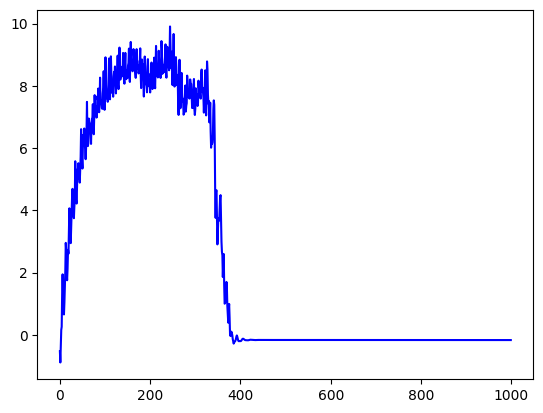

Average score:  27.574541371209705
Std score:  19.514255780328757
epoch loss:  9831.710082173347
sum of reward per episode:  7487.6250652592935
sum of reward per episode:  1063.3418668248055
sum of reward per episode:  899.8817578715868
sum of reward per episode:  6885.44488477413
sum of reward per episode:  9001.848738361994


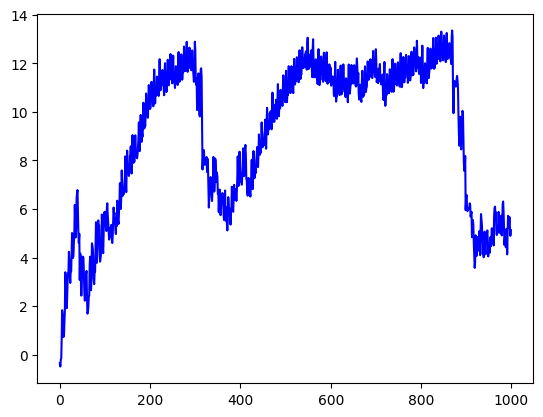

Average score:  43.07475096302284
Std score:  29.700166954846345
epoch loss:  3103.503413151484
sum of reward per episode:  10218.660061401839
sum of reward per episode:  51.035449237640165
sum of reward per episode:  9730.4416145223
sum of reward per episode:  10214.523853727665
sum of reward per episode:  9075.391596641763


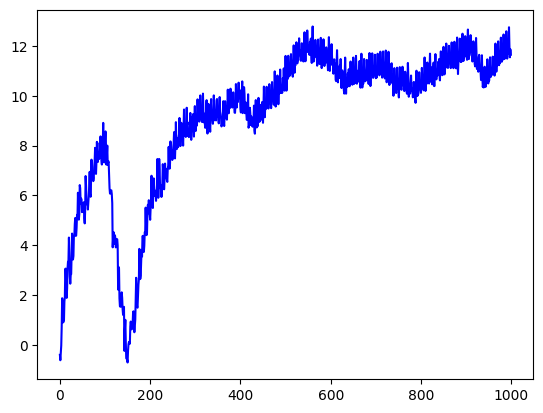

Average score:  65.55031948322984
Std score:  33.878365022231684
epoch loss:  -2010.0751864085905
sum of reward per episode:  11019.791927576287
sum of reward per episode:  10618.981051716259
sum of reward per episode:  556.5681083133778
sum of reward per episode:  11142.606018784589
sum of reward per episode:  3710.737943006051


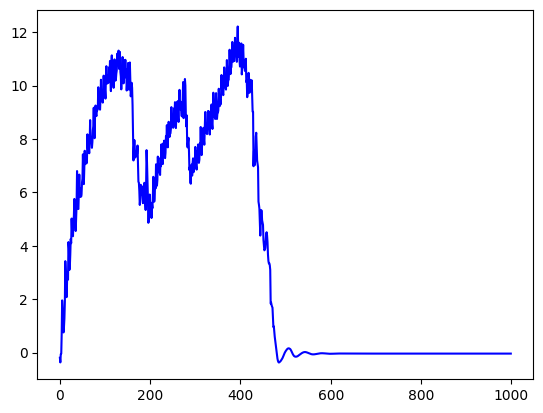

Average score:  61.93963044746239
Std score:  37.90068330174661
epoch loss:  -5164.797532141209
sum of reward per episode:  10164.079532438442
sum of reward per episode:  10490.932600067488
sum of reward per episode:  10481.509633280224
sum of reward per episode:  10550.298874599312
sum of reward per episode:  10522.142231130174


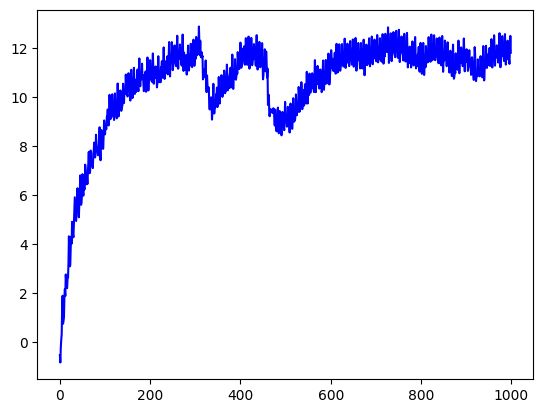

Average score:  86.36179605540283
Std score:  3.3921169544989893


KeyboardInterrupt: 

In [27]:
actor.to(device)
train_losses = []

for epoch in range(epochs):
    c = 0
    epoch_loss = 0.0
    actor.train()
    for x_batch, y_batch in train_loader:
        c += 1
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()


        loss = mle_loss(actor, x_batch, y_batch)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.0)

        optimizer.step()

        epoch_loss += loss.item()

    print('epoch loss: ', epoch_loss)
    train_losses.append(epoch_loss / len(train_loader))
    if epoch % 1 == 0:
        results = evaluate_on_env(actor, device, eval_env, return_target, 5, 1000,
                                states_mean, states_std, render=False, state_normalization=True)


        eval_d4rl_score = get_normalized_score(results['eval/avg_reward']) * 100
        eval_d4rl_std = get_normalized_score(results['eval/std_returns']) * 100
        print('Average score: ', eval_d4rl_score)
        print('Std score: ', eval_d4rl_std)

avg_train_loss = sum(train_losses) / len(train_losses)
print(f"\nAverage Training Loss: {avg_train_loss:.4f}")

# contrastive learning

In [28]:
discounted_rtgs = []

for p in paths:

  rtg = discount_cumsum(p['rewards'], gamma= 0.9)
  discounted_rtgs.append(rtg)

In [37]:
discounted_returns = np.concatenate(discounted_rtgs)

In [38]:
discounted_returns

array([ 9.446801 , 10.718757 , 13.241011 , ..., 21.143465 , 10.998188 ,
       -0.9166121], dtype=float32)

In [39]:
from collections import defaultdict

In [40]:
bin_count = 10
bin_edges = np.linspace(discounted_returns.min(), discounted_returns.max(), bin_count + 1)


binned_indices = np.digitize(discounted_returns, bin_edges, right=True)


bin_dict = defaultdict(list)
for idx, bin_idx in enumerate(binned_indices):
    bin_dict[bin_idx].append(idx)

In [41]:
bin_count = 10
hist, bin_edges = np.histogram(discounted_returns, bins=bin_count)

print("Bin edges:", bin_edges)
print("Bin counts:", hist)


for i in range(bin_count):
    low_edge, high_edge = bin_edges[i], bin_edges[i+1]
    print(f"Bin {i+1} range: [{low_edge:.2f}, {high_edge:.2f}) -> Count: {hist[i]}")

Bin edges: [ -9.877843    4.0699024  18.017647   31.965393   45.91314    59.86088
  73.80863    87.75637   101.70412   115.65186   129.59961  ]
Bin counts: [ 12079  20429  47631 251277 692602  50118  40352  78761 460077 343676]
Bin 1 range: [-9.88, 4.07) -> Count: 12079
Bin 2 range: [4.07, 18.02) -> Count: 20429
Bin 3 range: [18.02, 31.97) -> Count: 47631
Bin 4 range: [31.97, 45.91) -> Count: 251277
Bin 5 range: [45.91, 59.86) -> Count: 692602
Bin 6 range: [59.86, 73.81) -> Count: 50118
Bin 7 range: [73.81, 87.76) -> Count: 40352
Bin 8 range: [87.76, 101.70) -> Count: 78761
Bin 9 range: [101.70, 115.65) -> Count: 460077
Bin 10 range: [115.65, 129.60) -> Count: 343676


In [50]:
def sample_contrastive_minibatch(
    states,
    actions,
    discounted_returns,
    binned_indices,
    bin_dict,
    batch_size=64,
    num_negatives=4,
):
    import random
    import numpy as np

    anchor_indices = np.random.choice(len(states), size=batch_size, replace=False)

    anchor_states = states[anchor_indices]
    anchor_actions = actions[anchor_indices]
    anchor_returns = discounted_returns[anchor_indices]

    # Initialize negative actions array
    neg_actions = np.zeros((batch_size, num_negatives, actions.shape[1]))

    for i, anchor_idx in enumerate(anchor_indices):
        anchor_bin = binned_indices[anchor_idx]

        # Get indices from different bins
        diff_bin_indices = []
        for b, idx_list in bin_dict.items():
            if b != anchor_bin:
                diff_bin_indices.extend(idx_list)

        # Sample negative indices
        neg_idxs = np.random.choice(diff_bin_indices, size=num_negatives, replace=False)
        neg_actions[i] = actions[neg_idxs]

    # Add return values to states
    anchor_states_with_returns = np.concatenate([
        anchor_states,
        anchor_returns.reshape(-1, 1)
    ], axis=1)

    return anchor_states_with_returns, anchor_actions, neg_actions

In [ ]:
import torch

def contrastive_loss(
    policy,
    obs,         # shape [B, obs_dim]
    pos_actions, # shape [B, act_dim]
    neg_actions, # shape [B, 4, act_dim]
):
    B = obs.shape[0] #60
    Nneg = neg_actions.shape[1]  # 4

    # 1) Positive log-prob
    _, log_prob_pos, _ = policy.evaluate_actions(obs, pos_actions)
    # shape => [B]

    # 2) Negative log-probs (flatten them so SB3 can handle them)
    #    expand obs => [B*Nneg, obs_dim]
    obs_neg = (
        obs.unsqueeze(1)            # => [B, 1, obs_dim]
        .expand(-1, Nneg, -1)       # => [B, 4, obs_dim]
        .reshape(B * Nneg, -1)      # => [B*4, obs_dim]
    )
    neg_actions_flat = neg_actions.reshape(B * Nneg, -1)  # => [B*4, act_dim]

    _, log_prob_neg, _ = policy.evaluate_actions(obs_neg, neg_actions_flat)
    log_prob_neg = log_prob_neg.view(B, Nneg)  # => [B, 4]
    log_prob_neg_mean = log_prob_neg.mean(dim=1)  # => [B]

    # 3) Final loss
    # We want to *maximize* log_prob of positives => minimize(-log_prob_pos)
    # We want to *minimize* log_prob of negatives => add the negative log-probs
    loss = -log_prob_pos.mean() + log_prob_neg_mean.mean()

    return loss


### this part is not fully fixed , just changed the mle loss to the loss that i did
### could not run the code because i need the gpu on my colab and i have errors when running with the cpu
actor.to(device)
train_losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    actor.train()

    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        batch_size = x_batch.shape[0]

        # Sample contrastive batch
        anchor_states, anchor_actions, neg_actions = sample_contrastive_minibatch(
            normalized_states,
            actions,
            discounted_returns,
            binned_indices,
            bin_dict,
            batch_size=batch_size,
            num_negatives=4
        )

        # Convert to tensors and move to device
        anchor_states = torch.tensor(anchor_states, dtype=torch.float32).to(device)
        anchor_actions = torch.tensor(anchor_actions, dtype=torch.float32).to(device)
        neg_actions = torch.tensor(neg_actions, dtype=torch.float32).to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Calculate contrastive loss
        loss = contrastive_loss(
            actor,
            anchor_states,  # shape: [B, obs_dim + 1]
            anchor_actions, # shape: [B, act_dim]
            neg_actions    # shape: [B, num_negatives, act_dim]
        )

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.0)

        # Optimizer step
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}')

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}')
    train_losses.append(avg_epoch_loss)

    # Evaluation
    if epoch % 1 == 0:
        results = evaluate_on_env(
            actor, device, eval_env, return_target, 5, 1000,
            states_mean, states_std, render=False, state_normalization=True
        )

        eval_d4rl_score = get_normalized_score(results['eval/avg_reward']) * 100
        eval_d4rl_std = get_normalized_score(results['eval/std_returns']) * 100
        print(f'Average score: {eval_d4rl_score:.2f}')
        print(f'Std score: {eval_d4rl_std:.2f}')

avg_train_loss = sum(train_losses) / len(train_losses)
print(f"\nAverage Training Loss: {avg_train_loss:.4f}")

Epoch 1/100, Batch 0/3901, Loss: -504.5781
